# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def centroid_undersampling(data):
    '''Faz o undersampling pegando as amostras do centro do cluster
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    centrounder = ClusterCentroids(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = centrounder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = centrounder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = centroid_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [21]:
learnRate = 0.001
graficoName = "centroid-0.001-"

## RNA 1 (3)

In [23]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.3000 - acc: 0.6468 - val_loss: 0.3110 - val_acc: 0.6190
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2952 - acc: 0.6468 - val_loss: 0.3056 - val_acc: 0.6270
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2912 - acc: 0.6508 - val_loss: 0.3004 - val_acc: 0.6349
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.2870 - acc: 0.6587 - val_loss: 0.2947 - val_acc: 0.6270
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.2830 - acc: 0.6587 - val_loss: 0.2894 - val_acc: 0.6270
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.2784 - acc: 0.6627 - val_loss: 0.2843 - val_acc: 0.6190
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.2733 - acc: 0.6706 - val_loss: 0.2790 - val_acc: 0.6270
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2681 - acc

252/252 [==============================] - 0s - loss: 0.1461 - acc: 0.8373 - val_loss: 0.1574 - val_acc: 0.8095
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1459 - acc: 0.8373 - val_loss: 0.1571 - val_acc: 0.8095
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1455 - acc: 0.8294 - val_loss: 0.1566 - val_acc: 0.8095
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1453 - acc: 0.8373 - val_loss: 0.1561 - val_acc: 0.8095
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1449 - acc: 0.8452 - val_loss: 0.1558 - val_acc: 0.8095
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1446 - acc: 0.8452 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1443 - acc: 0.8452 - val_loss: 0.1551 - val_acc: 0.8175
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1440 - acc: 0.8452 - val_loss: 0.1548 - val_acc: 0.8175
Epoch 

252/252 [==============================] - 0s - loss: 0.1083 - acc: 0.8651 - val_loss: 0.1238 - val_acc: 0.8175
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1079 - acc: 0.8611 - val_loss: 0.1237 - val_acc: 0.8175
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1076 - acc: 0.8571 - val_loss: 0.1235 - val_acc: 0.8175
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8611 - val_loss: 0.1233 - val_acc: 0.8175
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8611 - val_loss: 0.1233 - val_acc: 0.8175
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1064 - acc: 0.8571 - val_loss: 0.1231 - val_acc: 0.8175
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1061 - acc: 0.8571 - val_loss: 0.1228 - val_acc: 0.8175
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8571 - val_loss: 0.1229 - val_acc: 0.8254

252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8929 - val_loss: 0.1165 - val_acc: 0.8651
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8929 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8968 - val_loss: 0.1155 - val_acc: 0.8730
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.9048 - val_loss: 0.1155 - val_acc: 0.8651
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8968 - val_loss: 0.1156 - val_acc: 0.8651
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8929 - val_loss: 0.1157 - val_acc: 0.8651
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8968 - val_loss: 0.1156 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.9008 - val_loss: 0.1123 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8810
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.9008 - val_loss: 0.1121 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.9008 - val_loss: 0.1121 - val_acc: 0.8810
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1121 - val_acc: 0.8810
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0920 - acc: 0.9048 - val_loss: 0.1122 - val_acc: 0.8810
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9087 - val_loss: 0.1118 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9048 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.9087 - val_loss: 0.1105 - val_acc: 0.8810
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.9048 - val_loss: 0.1105 - val_acc: 0.8810
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8968 - val_loss: 0.1108 - val_acc: 0.8810
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8968 - val_loss: 0.1105 - val_acc: 0.8810
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.9008 - val_loss: 0.1106 - val_acc: 0.8810
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9008 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9087 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9008 - val_loss: 0.1093 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8730
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8730
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8730
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8730
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9087 - val_loss: 0.1085 - val_acc: 0.8730
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1084 - val_acc: 0.8730
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8730
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1083 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8968 - val_loss: 0.1078 - val_acc: 0.8730
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8968 - val_loss: 0.1081 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8968 - val_loss: 0.1081 - val_acc: 0.8730
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8730
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1080 - val_acc: 0.8730
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1080 - val_acc: 0.8730
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8968 - val_loss: 0.1080 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1066 - val_acc: 0.8810
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1067 - val_acc: 0.8730
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9087 - val_loss: 0.1067 - val_acc: 0.8730
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1065 - val_acc: 0.8730
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9087 - val_loss: 0.1065 - val_acc: 0.8730
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1067 - val_acc: 0.8730
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1066 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1066 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9127 - val_loss: 0.1067 - val_acc: 0.8810
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9127 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9127 - val_loss: 0.1066 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9127 - val_loss: 0.1066 - val_acc: 0.8810
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9167 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9167 - val_loss: 0.1063 - val_acc: 0.8810
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9167 - val_loss: 0.1063 - val_acc: 0.8810
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9167 - val_loss: 0.1063 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9167 - val_loss: 0.1064 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9167 - val_loss: 0.1067 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9167 - val_loss: 0.1063 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9167 - val_loss: 0.1063 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9167 - val_loss: 0.1063 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9167 - val_loss: 0.1062 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9167 - val_loss: 0.1062 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9206 - val_loss: 0.1065 - val_acc: 0.8889
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9167 - val_loss: 0.1066 - val_acc: 0.8889
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9167 - val_loss: 0.1065 - val_acc: 0.8889
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9167 - val_loss: 0.1064 - val_acc: 0.8889
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9167 - val_loss: 0.1066 - val_acc: 0.8889
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9167 - val_loss: 0.1064 - val_acc: 0.8889
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9167 - val_loss: 0.1064 - val_acc: 0.8889
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9127 - val_loss: 0.1066 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9087 - val_loss: 0.1071 - val_acc: 0.8889
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9127 - val_loss: 0.1070 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9127 - val_loss: 0.1069 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9167 - val_loss: 0.1069 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9127 - val_loss: 0.1070 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9087 - val_loss: 0.1069 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9087 - val_loss: 0.1070 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9087 - val_loss: 0.1070 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9206 - val_loss: 0.1073 - val_acc: 0.8889
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9127 - val_loss: 0.1075 - val_acc: 0.8889
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9087 - val_loss: 0.1073 - val_acc: 0.8889
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9127 - val_loss: 0.1073 - val_acc: 0.8889
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1075 - val_acc: 0.8889
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9087 - val_loss: 0.1075 - val_acc: 0.8889
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9087 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9087 - val_loss: 0.1075 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9127 - val_loss: 0.1075 - val_acc: 0.8810
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9206 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9167 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9167 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9167 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9206 - val_loss: 0.1074 - val_acc: 0.8889
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9167 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9167 - val_loss: 0.1078 - val_acc:

252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9167 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 1088/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9167 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9167 - val_loss: 0.1078 - val_acc: 0.8810
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9167 - val_loss: 0.1077 - val_acc: 0.8810
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9206 - val_loss: 0.1077 - val_acc: 0.8810
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9206 - val_loss: 0.1075 - val_acc: 0.8810
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9167 - val_loss: 0.1077 - val_acc: 0.8810
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9167 - val_loss: 0.1077 - val_acc:

252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9167 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9206 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9206 - val_loss: 0.1082 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9206 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9206 - val_loss: 0.1082 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9206 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9127 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9167 - val_loss: 0.1081 - val_acc:

252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9206 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 1216/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9206 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9127 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9167 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9206 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9206 - val_loss: 0.1087 - val_acc: 0.8810
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9206 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9246 - val_loss: 0.1086 - val_acc:

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9087 - val_loss: 0.1088 - val_acc: 0.8810
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1089 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1089 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9087 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9127 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9127 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9087 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9087 - val_loss: 0.1091 - val_acc:

252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9127 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9127 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9127 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1098 - val_acc: 0.8810
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1102 - val_acc:

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9167 - val_loss: 0.1108 - val_acc: 0.8810
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9127 - val_loss: 0.1108 - val_acc: 0.8810
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9127 - val_loss: 0.1109 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9167 - val_loss: 0.1108 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1106 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1108 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9127 - val_loss: 0.1110 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9167 - val_loss: 0.1110 - val_acc:

252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9206 - val_loss: 0.1109 - val_acc: 0.8810
Epoch 1470/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9167 - val_loss: 0.1109 - val_acc: 0.8810
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9206 - val_loss: 0.1110 - val_acc: 0.8810
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9167 - val_loss: 0.1110 - val_acc: 0.8810
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9167 - val_loss: 0.1110 - val_acc: 0.8810
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9167 - val_loss: 0.1109 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9167 - val_loss: 0.1107 - val_acc: 0.8810
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9167 - val_loss: 0.1109 - val_acc:

252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9246 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 1533/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9246 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9246 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.1109 - val_acc: 0.8889
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.1109 - val_acc: 0.8968
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9246 - val_loss: 0.1108 - val_acc: 0.8968
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9246 - val_loss: 0.1109 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9246 - val_loss: 0.1110 - val_acc:

252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9206 - val_loss: 0.1113 - val_acc: 0.8889
Epoch 1597/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9246 - val_loss: 0.1112 - val_acc: 0.8968
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9246 - val_loss: 0.1114 - val_acc: 0.8889
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9246 - val_loss: 0.1113 - val_acc: 0.8889
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9246 - val_loss: 0.1113 - val_acc: 0.8889
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9246 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9246 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9246 - val_loss: 0.1112 - val_acc:

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9206 - val_loss: 0.1118 - val_acc: 0.8889
Epoch 1661/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9206 - val_loss: 0.1116 - val_acc: 0.8889
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9206 - val_loss: 0.1116 - val_acc: 0.8889
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9206 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9206 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9206 - val_loss: 0.1118 - val_acc: 0.8889
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9206 - val_loss: 0.1119 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9206 - val_loss: 0.1118 - val_acc:

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9206 - val_loss: 0.1122 - val_acc: 0.8889
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9206 - val_loss: 0.1124 - val_acc: 0.8968
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9206 - val_loss: 0.1121 - val_acc: 0.8889
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9206 - val_loss: 0.1121 - val_acc: 0.8889
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9206 - val_loss: 0.1122 - val_acc: 0.8889
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9206 - val_loss: 0.1122 - val_acc: 0.8889
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9206 - val_loss: 0.1121 - val_acc: 0.8889
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9206 - val_loss: 0.1123 - val_acc:

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9206 - val_loss: 0.1127 - val_acc: 0.8889
Epoch 1788/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9206 - val_loss: 0.1126 - val_acc: 0.8889
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9206 - val_loss: 0.1125 - val_acc: 0.8889
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9206 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9206 - val_loss: 0.1126 - val_acc: 0.8968
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9206 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9206 - val_loss: 0.1125 - val_acc:

252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9206 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 1852/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9206 - val_loss: 0.1132 - val_acc: 0.8889
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9206 - val_loss: 0.1130 - val_acc: 0.8889
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9206 - val_loss: 0.1132 - val_acc: 0.8889
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9206 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9206 - val_loss: 0.1132 - val_acc: 0.8968
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9206 - val_loss: 0.1130 - val_acc: 0.8889
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9206 - val_loss: 0.1129 - val_acc:

252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9206 - val_loss: 0.1135 - val_acc: 0.8889
Epoch 1915/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9206 - val_loss: 0.1136 - val_acc: 0.8889
Epoch 1916/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9206 - val_loss: 0.1133 - val_acc: 0.8889
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9206 - val_loss: 0.1135 - val_acc: 0.8968
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9206 - val_loss: 0.1135 - val_acc: 0.8968
Epoch 1919/2000
252/252 [==============================] - ETA: 0s - loss: 0.1087 - acc: 0.843 - 0s - loss: 0.0749 - acc: 0.9206 - val_loss: 0.1134 - val_acc: 0.8968
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9206 - val_loss: 0.1133 - val_acc: 0.8889
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc

252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9206 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 1978/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 1979/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9206 - val_loss: 0.1140 - val_acc: 0.8889
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9206 - val_loss: 0.1142 - val_acc: 0.8968
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9206 - val_loss: 0.1142 - val_acc: 0.8968
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9206 - val_loss: 0.1141 - val_acc: 0.8889
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.1137 - val_acc:

In [24]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.057775107412679723, 0.91488277255941963]


<IPython.core.display.Javascript object>


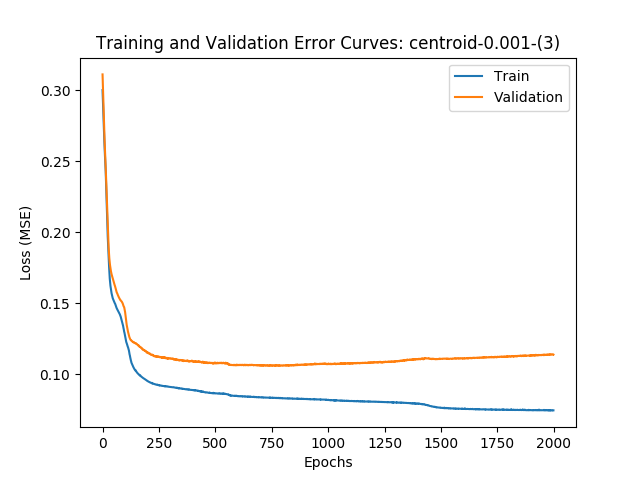

<IPython.core.display.Javascript object>


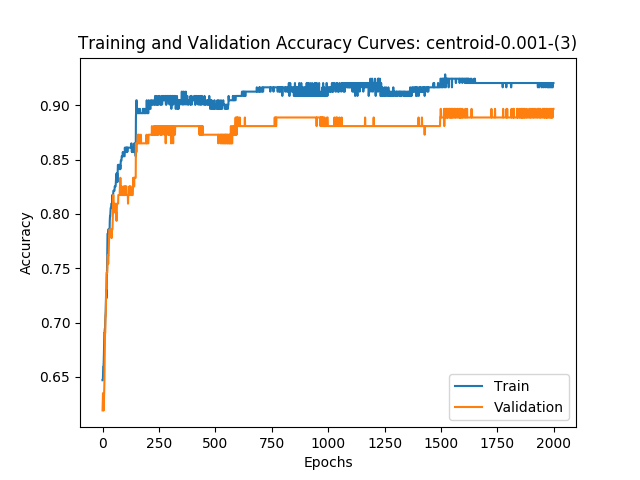

Matriz de confusão
[[1739  159]
 [   8   56]]

Train Loss:       0.0836
Validation Loss:  0.1060
Accuracy:         0.9149
MSE:              0.0851
AUROC:            0.9291


In [25]:
plot_training_error_curves(history, graficoName + "(3)")
plot_training_acc_curves(history, graficoName + "(3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [26]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4044 - acc: 0.4563 - val_loss: 0.3872 - val_acc: 0.4524
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3836 - acc: 0.4722 - val_loss: 0.3688 - val_acc: 0.4762
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.3670 - acc: 0.4921 - val_loss: 0.3517 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.3510 - acc: 0.4960 - val_loss: 0.3360 - val_acc: 0.5317
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3360 - acc: 0.5079 - val_loss: 0.3215 - val_acc: 0.5397
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3211 - acc: 0.5159 - val_loss: 0.3080 - val_acc: 0.5476
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3078 - acc: 0.5437 - val_loss: 0.2954 - val_acc: 0.5635
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2947 - acc

252/252 [==============================] - 0s - loss: 0.1055 - acc: 0.8770 - val_loss: 0.2127 - val_acc: 0.8254
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1053 - acc: 0.8770 - val_loss: 0.2094 - val_acc: 0.8254
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8770 - val_loss: 0.2085 - val_acc: 0.8254
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8690 - val_loss: 0.2091 - val_acc: 0.8254
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.2104 - val_acc: 0.8254
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8770 - val_loss: 0.2108 - val_acc: 0.8254
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1038 - acc: 0.8770 - val_loss: 0.2103 - val_acc: 0.8254
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1036 - acc: 0.8730 - val_loss: 0.2092 - val_acc: 0.8254
Epoch 

252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8810 - val_loss: 0.1875 - val_acc: 0.8492
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8770 - val_loss: 0.1874 - val_acc: 0.8492
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1883 - val_acc: 0.8492
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8770 - val_loss: 0.1879 - val_acc: 0.8492
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8770 - val_loss: 0.1872 - val_acc: 0.8492
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8810 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8810 - val_loss: 0.1853 - val_acc: 0.8492
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1849 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1658 - val_acc: 0.8571
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1672 - val_acc: 0.8571
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.8889 - val_loss: 0.1653 - val_acc: 0.8571
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.8929 - val_loss: 0.1640 - val_acc: 0.8651
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8929 - val_loss: 0.1648 - val_acc: 0.8571
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8929 - val_loss: 0.1649 - val_acc: 0.8571
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.8929 - val_loss: 0.1655 - val_acc: 0.8571
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8929 - val_loss: 0.1666 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1544 - val_acc: 0.8571
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1550 - val_acc: 0.8571
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.8968 - val_loss: 0.1538 - val_acc: 0.8571
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1519 - val_acc: 0.8571
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1529 - val_acc: 0.8571
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1527 - val_acc: 0.8571
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.8968 - val_loss: 0.1521 - val_acc: 0.8571
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.8968 - val_loss: 0.1537 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1472 - val_acc: 0.8571
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9008 - val_loss: 0.1484 - val_acc: 0.8571
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9008 - val_loss: 0.1472 - val_acc: 0.8571
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1481 - val_acc: 0.8730
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1483 - val_acc: 0.8730
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8730
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8651
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1473 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1453 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1447 - val_acc: 0.8651
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1443 - val_acc: 0.8651
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1436 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1449 - val_acc: 0.8651
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1444 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1439 - val_acc: 0.8571
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9008 - val_loss: 0.1437 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1424 - val_acc: 0.8651
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1418 - val_acc: 0.8651
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1430 - val_acc: 0.8651
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1426 - val_acc: 0.8730
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1440 - val_acc: 0.8730
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1430 - val_acc: 0.8730
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1422 - val_acc: 0.8651
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1430 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1408 - val_acc: 0.8730
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9008 - val_loss: 0.1420 - val_acc: 0.8730
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1420 - val_acc: 0.8730
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1408 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1403 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1398 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1404 - val_acc: 0.8730
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1403 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1364 - val_acc: 0.8730
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9008 - val_loss: 0.1382 - val_acc: 0.8730
Epoch 579/2000
252/252 [==============================] - ETA: 0s - loss: 0.1061 - acc: 0.906 - 0s - loss: 0.0811 - acc: 0.9008 - val_loss: 0.1370 - val_acc: 0.8730
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1378 - val_acc: 0.8730
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1371 - val_acc: 0.8730
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1375 - val_acc: 0.8730
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8730
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.900

252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1364 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1360 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1360 - val_acc: 0.8730
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9048 - val_loss: 0.1359 - val_acc: 0.8730
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1358 - val_acc: 0.8730
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1346 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1355 - val_acc: 0.8730
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9048 - val_loss: 0.1355 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9048 - val_loss: 0.1331 - val_acc: 0.8730
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1326 - val_acc: 0.8730
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1318 - val_acc: 0.8730
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1318 - val_acc: 0.8810
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8810
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9048 - val_loss: 0.1332 - val_acc: 0.8730
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1335 - val_acc: 0.8730
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9048 - val_loss: 0.1328 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9048 - val_loss: 0.1299 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1303 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1302 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1303 - val_acc: 0.8810
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1300 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9048 - val_loss: 0.1301 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1304 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1309 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1278 - val_acc: 0.8810
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1270 - val_acc: 0.8810
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1271 - val_acc: 0.8810
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1274 - val_acc: 0.8810
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1274 - val_acc: 0.8810
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1275 - val_acc: 0.8810
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.8810
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1272 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1240 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1245 - val_acc: 0.8810
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1244 - val_acc: 0.8810
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1240 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1239 - val_acc: 0.8810
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1237 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1205 - val_acc: 0.8810
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1206 - val_acc: 0.8810
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1208 - val_acc: 0.8889
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1211 - val_acc: 0.8889
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1212 - val_acc: 0.8889
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8889
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1212 - val_acc: 0.8889
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1207 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8889
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1185 - val_acc: 0.8889
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1183 - val_acc: 0.8889
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8889
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9087 - val_loss: 0.1181 - val_acc: 0.8889
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9087 - val_loss: 0.1180 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8889
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1186 - val_acc:

252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1167 - val_acc: 0.8889
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1171 - val_acc: 0.8889
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9087 - val_loss: 0.1170 - val_acc: 0.8889
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1168 - val_acc: 0.8889
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9087 - val_loss: 0.1160 - val_acc: 0.8889
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1164 - val_acc:

252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1145 - val_acc: 0.8889
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1145 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1148 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1144 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - ETA: 0s - loss: 0.0662 - acc: 0.937 - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc

252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1127 - val_acc: 0.8810
Epoch 1216/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1122 - val_acc: 0.8889
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1123 - val_acc: 0.8889
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1122 - val_acc: 0.8889
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1126 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - ETA: 0s - loss: 0.0620 - acc: 0.968 - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1125 - val_acc: 0.8889
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc

252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1113 - val_acc: 0.8889
Epoch 1279/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1114 - val_acc: 0.8810
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1116 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1112 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1109 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1111 - val_acc:

252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1095 - val_acc: 0.8889
Epoch 1343/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1095 - val_acc: 0.8889
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1093 - val_acc: 0.8889
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1094 - val_acc: 0.8889
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1101 - val_acc: 0.8889
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1091 - val_acc: 0.8889
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1090 - val_acc:

252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1069 - val_acc: 0.8889
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.1069 - val_acc: 0.8889
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1063 - val_acc: 0.8889
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.1065 - val_acc: 0.8889
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.1064 - val_acc: 0.8889
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.1066 - val_acc: 0.8889
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1069 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1068 - val_acc:

252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.1061 - val_acc: 0.8810
Epoch 1470/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1062 - val_acc: 0.8810
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.1057 - val_acc: 0.8889
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9087 - val_loss: 0.1054 - val_acc: 0.8889
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9087 - val_loss: 0.1056 - val_acc: 0.8889
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1059 - val_acc: 0.8889
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1057 - val_acc: 0.8889
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9087 - val_loss: 0.1054 - val_acc:

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9087 - val_loss: 0.1051 - val_acc: 0.8889
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1051 - val_acc: 0.8889
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1047 - val_acc: 0.8889
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9087 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9087 - val_loss: 0.1047 - val_acc: 0.8889
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.1049 - val_acc:

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9087 - val_loss: 0.1044 - val_acc: 0.8889
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9087 - val_loss: 0.1041 - val_acc: 0.8889
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1041 - val_acc: 0.8889
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1041 - val_acc: 0.8889
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1042 - val_acc: 0.8889
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1040 - val_acc: 0.8889
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1040 - val_acc: 0.8889
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1038 - val_acc:

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1038 - val_acc: 0.8889
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1037 - val_acc: 0.8889
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1037 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1041 - val_acc: 0.8889
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1040 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1038 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1038 - val_acc:

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9127 - val_loss: 0.1040 - val_acc: 0.8889
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1040 - val_acc: 0.8810
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1038 - val_acc:

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9127 - val_loss: 0.1032 - val_acc: 0.8810
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1030 - val_acc: 0.8810
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9127 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1034 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1032 - val_acc:

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1028 - val_acc: 0.8810
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9127 - val_loss: 0.1028 - val_acc: 0.8810
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1030 - val_acc: 0.8810
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.1034 - val_acc: 0.8810
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1028 - val_acc: 0.8810
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9127 - val_loss: 0.1028 - val_acc: 0.8810
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9127 - val_loss: 0.1029 - val_acc:

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9127 - val_loss: 0.1026 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1024 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9127 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9127 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.1028 - val_acc:

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9127 - val_loss: 0.1030 - val_acc: 0.8810
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9127 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9127 - val_loss: 0.1032 - val_acc: 0.8810
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9127 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1030 - val_acc: 0.8730
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9127 - val_loss: 0.1027 - val_acc:

In [27]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.089438397448726392, 0.87869520903119736]


<IPython.core.display.Javascript object>


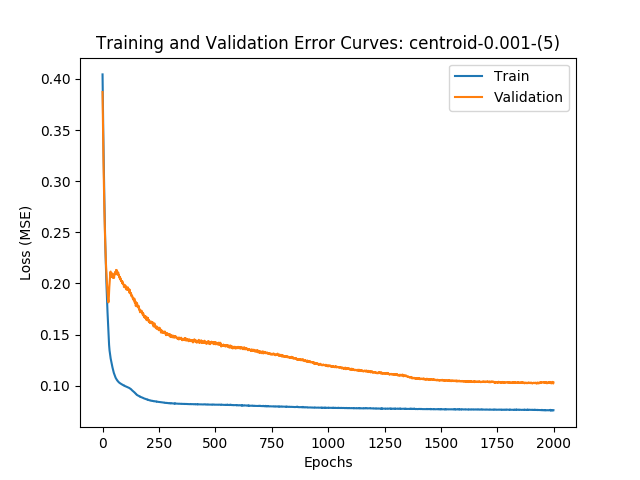

<IPython.core.display.Javascript object>


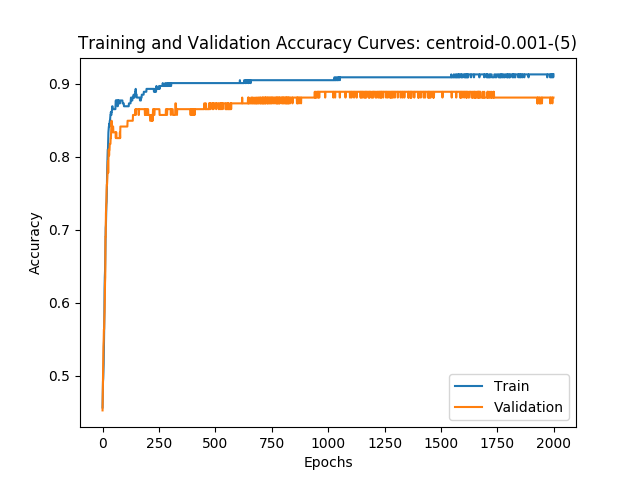

Matriz de confusão
[[1668  230]
 [   8   56]]

Train Loss:       0.0762
Validation Loss:  0.1019
Accuracy:         0.8787
MSE:              0.1213
AUROC:            0.9292


In [28]:
plot_training_error_curves(history, graficoName + "(5)")
plot_training_acc_curves(history, graficoName + "(5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (3, 5)

In [31]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4788 - acc: 0.5000 - val_loss: 0.4737 - val_acc: 0.5000
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4567 - acc: 0.5000 - val_loss: 0.4553 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4358 - acc: 0.5000 - val_loss: 0.4368 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4156 - acc: 0.5000 - val_loss: 0.4172 - val_acc: 0.5000
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3929 - acc: 0.5079 - val_loss: 0.3969 - val_acc: 0.5079
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3721 - acc: 0.5119 - val_loss: 0.3765 - val_acc: 0.5238
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3506 - acc: 0.5278 - val_loss: 0.3562 - val_acc: 0.5238
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.3267 - acc

252/252 [==============================] - 0s - loss: 0.1210 - acc: 0.8492 - val_loss: 0.1391 - val_acc: 0.8254
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1206 - acc: 0.8452 - val_loss: 0.1387 - val_acc: 0.8254
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1202 - acc: 0.8452 - val_loss: 0.1383 - val_acc: 0.8254
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1199 - acc: 0.8452 - val_loss: 0.1379 - val_acc: 0.8254
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1195 - acc: 0.8452 - val_loss: 0.1375 - val_acc: 0.8254
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8452 - val_loss: 0.1371 - val_acc: 0.8254
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1188 - acc: 0.8452 - val_loss: 0.1368 - val_acc: 0.8333
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1185 - acc: 0.8452 - val_loss: 0.1363 - val_acc: 0.8333
Epoch 

252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1227 - val_acc: 0.8492
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8770 - val_loss: 0.1223 - val_acc: 0.8492
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8770 - val_loss: 0.1225 - val_acc: 0.8492
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8849 - val_loss: 0.1229 - val_acc: 0.8492
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8849 - val_loss: 0.1224 - val_acc: 0.8492
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8849 - val_loss: 0.1225 - val_acc: 0.8492
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8849 - val_loss: 0.1222 - val_acc: 0.8492
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8849 - val_loss: 0.1220 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8929 - val_loss: 0.1163 - val_acc: 0.8730
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8889 - val_loss: 0.1164 - val_acc: 0.8730
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8929 - val_loss: 0.1170 - val_acc: 0.8730
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8929 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8929 - val_loss: 0.1167 - val_acc: 0.8730
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8929 - val_loss: 0.1164 - val_acc: 0.8730
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1162 - val_acc: 0.8730
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8929 - val_loss: 0.1158 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.8929 - val_loss: 0.1136 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.8929 - val_loss: 0.1127 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8929 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8849 - val_loss: 0.1125 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.8849 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.8849 - val_loss: 0.1123 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.8849 - val_loss: 0.1127 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.8929 - val_loss: 0.1128 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.8889 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.8889 - val_loss: 0.1093 - val_acc: 0.8651
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.8849 - val_loss: 0.1077 - val_acc: 0.8651
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.8889 - val_loss: 0.1076 - val_acc: 0.8651
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.8849 - val_loss: 0.1083 - val_acc: 0.8730
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.8849 - val_loss: 0.1081 - val_acc: 0.8730
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.8889 - val_loss: 0.1077 - val_acc: 0.8651
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.8889 - val_loss: 0.1077 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.8889 - val_loss: 0.1045 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.8929 - val_loss: 0.1043 - val_acc: 0.8730
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.8929 - val_loss: 0.1043 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.8929 - val_loss: 0.1047 - val_acc: 0.8730
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.8889 - val_loss: 0.1042 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.8889 - val_loss: 0.1041 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.8929 - val_loss: 0.1040 - val_acc: 0.8730
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.8889 - val_loss: 0.1038 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.1019 - val_acc: 0.8730
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8730
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.1019 - val_acc: 0.8730
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.1027 - val_acc: 0.8730
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.1024 - val_acc: 0.8730
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.1023 - val_acc: 0.8730
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.1028 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8730
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9008 - val_loss: 0.1013 - val_acc: 0.8730
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9008 - val_loss: 0.1008 - val_acc: 0.8730
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9008 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8730
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9008 - val_loss: 0.1018 - val_acc: 0.8730
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9008 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9008 - val_loss: 0.1012 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8968 - val_loss: 0.1008 - val_acc: 0.8651
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.8968 - val_loss: 0.1002 - val_acc: 0.8651
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8651
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9008 - val_loss: 0.1011 - val_acc: 0.8730
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8651
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.8968 - val_loss: 0.1011 - val_acc: 0.8651
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9008 - val_loss: 0.1017 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9008 - val_loss: 0.1008 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9008 - val_loss: 0.1013 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9008 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.8968 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.8968 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.8968 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9008 - val_loss: 0.1010 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.8968 - val_loss: 0.1001 - val_acc: 0.8730
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.8968 - val_loss: 0.1002 - val_acc: 0.8730
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.8968 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.8968 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.8968 - val_loss: 0.1004 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.8968 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.1001 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.1000 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.1008 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.1008 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9008 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9008 - val_loss: 0.1001 - val_acc: 0.8730
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.8968 - val_loss: 0.1000 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9008 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.8968 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.8968 - val_loss: 0.1000 - val_acc: 0.8730
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9008 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9008 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9008 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9008 - val_loss: 0.1005 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.8968 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9008 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9008 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9008 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.8968 - val_loss: 0.1000 - val_acc: 0.8730
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.8968 - val_loss: 0.1003 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.8968 - val_loss: 0.1002 - val_acc: 0.8730
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9008 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9008 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9008 - val_loss: 0.1011 - val_acc: 0.8730
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.8968 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9008 - val_loss: 0.1010 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9008 - val_loss: 0.1015 - val_acc: 0.8730
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9008 - val_loss: 0.1016 - val_acc: 0.8730
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9008 - val_loss: 0.1013 - val_acc: 0.8730
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9008 - val_loss: 0.1001 - val_acc: 0.8730
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.8968 - val_loss: 0.0999 - val_acc: 0.8730
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.8968 - val_loss: 0.1005 - val_acc:

252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9008 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9008 - val_loss: 0.1002 - val_acc: 0.8730
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9008 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9008 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9008 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9008 - val_loss: 0.1008 - val_acc: 0.8730
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.8968 - val_loss: 0.0999 - val_acc:

252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9008 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9008 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9008 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9008 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9008 - val_loss: 0.1011 - val_acc: 0.8730
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9008 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9008 - val_loss: 0.1007 - val_acc:

252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.8968 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1216/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9008 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9008 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.8968 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9008 - val_loss: 0.1014 - val_acc: 0.8730
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9008 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9008 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9008 - val_loss: 0.1009 - val_acc:

252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.8968 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.8968 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.8968 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.8968 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.8929 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.8929 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.8968 - val_loss: 0.1005 - val_acc:

252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8929 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8968 - val_loss: 0.1001 - val_acc: 0.8730
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.8968 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.8929 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.8968 - val_loss: 0.1007 - val_acc:

252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.8929 - val_loss: 0.1002 - val_acc: 0.8730
Epoch 1408/2000
252/252 [==============================] - ETA: 0s - loss: 0.0656 - acc: 0.906 - 0s - loss: 0.0703 - acc: 0.8929 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.8968 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.8929 - val_loss: 0.1002 - val_acc: 0.8730
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.8929 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.8929 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc

252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.8929 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8889 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.8929 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.8929 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.8929 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1004 - val_acc:

252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1008 - val_acc: 0.8730
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.8929 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.8929 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.8929 - val_loss: 0.1011 - val_acc: 0.8730
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.8929 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.8929 - val_loss: 0.1012 - val_acc:

252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.8929 - val_loss: 0.1007 - val_acc: 0.8730
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.8929 - val_loss: 0.1014 - val_acc: 0.8730
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.8929 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.8929 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.8929 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.8929 - val_loss: 0.1016 - val_acc: 0.8651
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.8929 - val_loss: 0.1020 - val_acc: 0.8651
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.8929 - val_loss: 0.1016 - val_acc:

252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.8929 - val_loss: 0.1011 - val_acc: 0.8651
Epoch 1661/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.8929 - val_loss: 0.1011 - val_acc: 0.8651
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.8929 - val_loss: 0.1009 - val_acc: 0.8651
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.8929 - val_loss: 0.1014 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1013 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.8929 - val_loss: 0.1013 - val_acc: 0.8571
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.8929 - val_loss: 0.1009 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.8929 - val_loss: 0.1009 - val_acc:

252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1015 - val_acc: 0.8651
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.8968 - val_loss: 0.1012 - val_acc: 0.8651
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1009 - val_acc: 0.8651
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1012 - val_acc: 0.8571
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.8929 - val_loss: 0.1015 - val_acc: 0.8651
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1015 - val_acc: 0.8651
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8968 - val_loss: 0.1012 - val_acc: 0.8651
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1012 - val_acc:

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8929 - val_loss: 0.1015 - val_acc: 0.8651
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.8968 - val_loss: 0.1013 - val_acc: 0.8651
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.8968 - val_loss: 0.1008 - val_acc: 0.8651
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1013 - val_acc: 0.8571
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8929 - val_loss: 0.1005 - val_acc: 0.8651
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.8968 - val_loss: 0.1007 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.8968 - val_loss: 0.1010 - val_acc: 0.8571
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.8929 - val_loss: 0.1011 - val_acc:

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8929 - val_loss: 0.1011 - val_acc: 0.8571
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8929 - val_loss: 0.1011 - val_acc: 0.8571
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8929 - val_loss: 0.1009 - val_acc: 0.8651
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.8968 - val_loss: 0.1011 - val_acc: 0.8651
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8968 - val_loss: 0.1011 - val_acc: 0.8651
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8929 - val_loss: 0.1011 - val_acc: 0.8571
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.8929 - val_loss: 0.1010 - val_acc: 0.8651
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8968 - val_loss: 0.1009 - val_acc:

252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8929 - val_loss: 0.1012 - val_acc: 0.8571
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.8929 - val_loss: 0.1020 - val_acc: 0.8571
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8929 - val_loss: 0.1018 - val_acc: 0.8571
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8968 - val_loss: 0.1009 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8968 - val_loss: 0.1000 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8651
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8968 - val_loss: 0.1007 - val_acc: 0.8651
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.8929 - val_loss: 0.1010 - val_acc:

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.8968 - val_loss: 0.1014 - val_acc: 0.8571
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8968 - val_loss: 0.1016 - val_acc: 0.8571
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8571
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8968 - val_loss: 0.1012 - val_acc: 0.8651
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.8968 - val_loss: 0.1014 - val_acc: 0.8571
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8968 - val_loss: 0.1007 - val_acc: 0.8651
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.8968 - val_loss: 0.1012 - val_acc: 0.8571
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.8929 - val_loss: 0.1014 - val_acc:

In [32]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.08915088026500502, 0.89806320069397627]


<IPython.core.display.Javascript object>


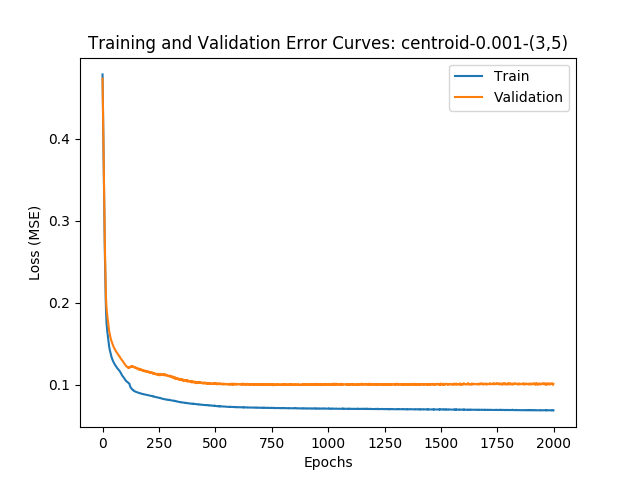

<IPython.core.display.Javascript object>


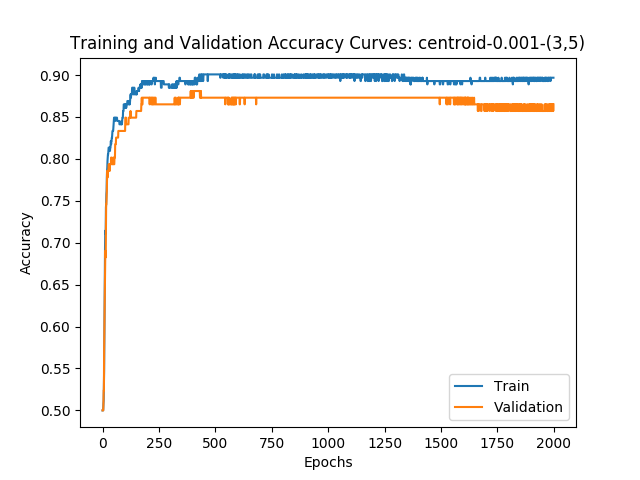

Matriz de confusão
[[1704  194]
 [   6   58]]

Train Loss:       0.0721
Validation Loss:  0.0995
Accuracy:         0.8981
MSE:              0.1019
AUROC:            0.9401


In [33]:
plot_training_error_curves(history, graficoName + "(3,5)")
plot_training_acc_curves(history, graficoName + "(3,5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [35]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5786 - acc: 0.3968 - val_loss: 0.5386 - val_acc: 0.4444
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5517 - acc: 0.4048 - val_loss: 0.5184 - val_acc: 0.4524
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5292 - acc: 0.4167 - val_loss: 0.5002 - val_acc: 0.4524
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5078 - acc: 0.4206 - val_loss: 0.4849 - val_acc: 0.4603
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4900 - acc: 0.4167 - val_loss: 0.4706 - val_acc: 0.4683
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4751 - acc: 0.4206 - val_loss: 0.4571 - val_acc: 0.4683
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4591 - acc: 0.4286 - val_loss: 0.4451 - val_acc: 0.4603
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4448 - acc

252/252 [==============================] - 0s - loss: 0.1129 - acc: 0.8730 - val_loss: 0.1941 - val_acc: 0.8571
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8690 - val_loss: 0.1946 - val_acc: 0.8571
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1122 - acc: 0.8730 - val_loss: 0.1941 - val_acc: 0.8571
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1117 - acc: 0.8690 - val_loss: 0.1926 - val_acc: 0.8571
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1116 - acc: 0.8651 - val_loss: 0.1912 - val_acc: 0.8571
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8651 - val_loss: 0.1908 - val_acc: 0.8571
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1107 - acc: 0.8651 - val_loss: 0.1902 - val_acc: 0.8571
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8651 - val_loss: 0.1900 - val_acc: 0.8571
Epoch 

252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1611 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0968 - acc: 0.8889 - val_loss: 0.1610 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0967 - acc: 0.8889 - val_loss: 0.1605 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8889 - val_loss: 0.1601 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0964 - acc: 0.8849 - val_loss: 0.1597 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8849 - val_loss: 0.1594 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8889 - val_loss: 0.1591 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8889 - val_loss: 0.1590 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8849 - val_loss: 0.1482 - val_acc: 0.8730
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8889 - val_loss: 0.1478 - val_acc: 0.8730
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8968 - val_loss: 0.1478 - val_acc: 0.8730
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1480 - val_acc: 0.8730
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8889 - val_loss: 0.1486 - val_acc: 0.8730
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8849 - val_loss: 0.1474 - val_acc: 0.8730
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1478 - val_acc: 0.8730
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8929 - val_loss: 0.1484 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9008 - val_loss: 0.1401 - val_acc: 0.8889
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9008 - val_loss: 0.1402 - val_acc: 0.8889
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9008 - val_loss: 0.1394 - val_acc: 0.8889
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1396 - val_acc: 0.8889
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9008 - val_loss: 0.1395 - val_acc: 0.8889
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9008 - val_loss: 0.1399 - val_acc: 0.8810
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9008 - val_loss: 0.1391 - val_acc: 0.8810
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9008 - val_loss: 0.1393 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.8929 - val_loss: 0.1375 - val_acc: 0.8651
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.8929 - val_loss: 0.1373 - val_acc: 0.8651
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.8929 - val_loss: 0.1377 - val_acc: 0.8651
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.8929 - val_loss: 0.1378 - val_acc: 0.8651
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8651
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.8929 - val_loss: 0.1371 - val_acc: 0.8651
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.8889 - val_loss: 0.1374 - val_acc: 0.8651
Epoch 328/2000
252/252 [==============================] - ETA: 0s - loss: 0.0196 - acc: 1.000 - 0s - loss: 0.0806 - acc: 0.892

252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9008 - val_loss: 0.1346 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9048 - val_loss: 0.1350 - val_acc: 0.8889
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9008 - val_loss: 0.1353 - val_acc: 0.8889
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9008 - val_loss: 0.1350 - val_acc: 0.8889
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9048 - val_loss: 0.1341 - val_acc: 0.8889
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9048 - val_loss: 0.1339 - val_acc: 0.8889
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9048 - val_loss: 0.1342 - val_acc: 0.8889
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9008 - val_loss: 0.1342 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.1243 - val_acc: 0.8889
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8889
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.1242 - val_acc: 0.8889
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.1246 - val_acc: 0.8810
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.1246 - val_acc: 0.8810
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9008 - val_loss: 0.1240 - val_acc: 0.8889
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8889
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.1240 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9048 - val_loss: 0.1192 - val_acc: 0.8889
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9048 - val_loss: 0.1190 - val_acc: 0.8889
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9048 - val_loss: 0.1187 - val_acc: 0.8889
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8889
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8889
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9048 - val_loss: 0.1185 - val_acc: 0.8889
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9048 - val_loss: 0.1182 - val_acc: 0.8889
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9048 - val_loss: 0.1148 - val_acc: 0.8889
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9087 - val_loss: 0.1141 - val_acc: 0.8889
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9048 - val_loss: 0.1130 - val_acc: 0.8889
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9048 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9048 - val_loss: 0.1141 - val_acc: 0.8889
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9048 - val_loss: 0.1138 - val_acc: 0.8889
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9048 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9087 - val_loss: 0.1138 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9127 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9087 - val_loss: 0.1108 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9127 - val_loss: 0.1109 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9127 - val_loss: 0.1106 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.1105 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.1102 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9087 - val_loss: 0.1089 - val_acc: 0.8889
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9087 - val_loss: 0.1086 - val_acc: 0.8889
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9087 - val_loss: 0.1093 - val_acc: 0.8889
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9087 - val_loss: 0.1098 - val_acc: 0.8889
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9087 - val_loss: 0.1100 - val_acc: 0.8889
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9087 - val_loss: 0.1089 - val_acc: 0.8889
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9087 - val_loss: 0.1090 - val_acc: 0.8889
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.1092 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1084 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1081 - val_acc: 0.8889
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9048 - val_loss: 0.1074 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1072 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9087 - val_loss: 0.1072 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9048 - val_loss: 0.1076 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1079 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1076 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9048 - val_loss: 0.1057 - val_acc: 0.8889
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9048 - val_loss: 0.1058 - val_acc: 0.8889
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9048 - val_loss: 0.1055 - val_acc: 0.8889
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9048 - val_loss: 0.1063 - val_acc: 0.8889
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9048 - val_loss: 0.1068 - val_acc: 0.8889
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9048 - val_loss: 0.1065 - val_acc: 0.8889
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9048 - val_loss: 0.1064 - val_acc: 0.8889
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9048 - val_loss: 0.1058 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9048 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9048 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9048 - val_loss: 0.1048 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - ETA: 0s - loss: 0.0474 - acc: 0.937 - 0s - loss: 0.0714 - acc: 0.9048 - val_loss: 0.1059 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9048 - val_loss: 0.1066 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9048 - val_loss: 0.1060 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9048 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.904

252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9048 - val_loss: 0.1053 - val_acc: 0.8810
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8889
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9048 - val_loss: 0.1043 - val_acc: 0.8889
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9048 - val_loss: 0.1049 - val_acc: 0.8889
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9048 - val_loss: 0.1056 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9048 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9048 - val_loss: 0.1046 - val_acc: 0.8889
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968

252/252 [==============================] - ETA: 0s - loss: 0.0497 - acc: 0.875 - 0s - loss: 0.0707 - acc: 0.9048 - val_loss: 0.1028 - val_acc: 0.8730
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8730
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9048 - val_loss: 0.1030 - val_acc: 0.8730
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8730
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9048 - val_loss: 0.1043 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8968
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8730
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc

252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8730
Epoch 1088/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1020 - val_acc: 0.8730
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8730
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1026 - val_acc: 0.8651
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9087 - val_loss: 0.1025 - val_acc: 0.8730
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1024 - val_acc: 0.8730
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1022 - val_acc: 0.8730
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1016 - val_acc:

252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8810
Epoch 1151/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9127 - val_loss: 0.1009 - val_acc: 0.8810
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9087 - val_loss: 0.1005 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9087 - val_loss: 0.1014 - val_acc: 0.8730
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9087 - val_loss: 0.1010 - val_acc:

252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.1008 - val_acc: 0.8810
Epoch 1215/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9127 - val_loss: 0.1001 - val_acc: 0.8810
Epoch 1216/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9127 - val_loss: 0.1000 - val_acc: 0.8810
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9127 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9127 - val_loss: 0.1018 - val_acc: 0.8730
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8810
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1007 - val_acc:

252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9127 - val_loss: 0.0998 - val_acc: 0.8810
Epoch 1278/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9127 - val_loss: 0.1008 - val_acc: 0.8730
Epoch 1279/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9127 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.0999 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9127 - val_loss: 0.1001 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9127 - val_loss: 0.0991 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9127 - val_loss: 0.0993 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9127 - val_loss: 0.0999 - val_acc:

252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9127 - val_loss: 0.1005 - val_acc: 0.8730
Epoch 1341/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9127 - val_loss: 0.0988 - val_acc: 0.8810
Epoch 1342/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9127 - val_loss: 0.0984 - val_acc: 0.8810
Epoch 1343/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9127 - val_loss: 0.0987 - val_acc: 0.8810
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9127 - val_loss: 0.0993 - val_acc: 0.8810
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9087 - val_loss: 0.0995 - val_acc: 0.8810
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9127 - val_loss: 0.1002 - val_acc: 0.8730
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9127 - val_loss: 0.0991 - val_acc:

252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9127 - val_loss: 0.0976 - val_acc: 0.8889
Epoch 1405/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9127 - val_loss: 0.0976 - val_acc: 0.8889
Epoch 1406/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9127 - val_loss: 0.0981 - val_acc: 0.8810
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9127 - val_loss: 0.0988 - val_acc: 0.8810
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9127 - val_loss: 0.0981 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9127 - val_loss: 0.0984 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9127 - val_loss: 0.0984 - val_acc: 0.8889
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9127 - val_loss: 0.0975 - val_acc:

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9127 - val_loss: 0.0977 - val_acc: 0.8810
Epoch 1468/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9127 - val_loss: 0.0971 - val_acc: 0.8810
Epoch 1469/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9127 - val_loss: 0.0973 - val_acc: 0.8810
Epoch 1470/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9127 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9127 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9127 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9127 - val_loss: 0.0964 - val_acc: 0.8889
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9127 - val_loss: 0.0968 - val_acc:

252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9087 - val_loss: 0.0965 - val_acc: 0.8810
Epoch 1532/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9127 - val_loss: 0.0974 - val_acc: 0.8810
Epoch 1533/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9127 - val_loss: 0.0972 - val_acc: 0.8810
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9087 - val_loss: 0.0970 - val_acc: 0.8730
Epoch 1535/2000
252/252 [==============================] - ETA: 0s - loss: 0.0956 - acc: 0.875 - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0957 - val_acc: 0.8889
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc

252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0962 - val_acc: 0.8810
Epoch 1595/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9087 - val_loss: 0.0972 - val_acc: 0.8810
Epoch 1596/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.0960 - val_acc: 0.8810
Epoch 1597/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9087 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9087 - val_loss: 0.0955 - val_acc: 0.8810
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9087 - val_loss: 0.0978 - val_acc: 0.8730
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9127 - val_loss: 0.0983 - val_acc: 0.8730
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.0956 - val_acc:

252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9087 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1659/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9087 - val_loss: 0.0951 - val_acc: 0.8889
Epoch 1660/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9087 - val_loss: 0.0963 - val_acc: 0.8810
Epoch 1661/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9087 - val_loss: 0.0960 - val_acc: 0.8810
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9087 - val_loss: 0.0947 - val_acc: 0.8968
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9087 - val_loss: 0.0954 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9087 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9087 - val_loss: 0.0962 - val_acc:

252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9087 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1722/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9087 - val_loss: 0.0965 - val_acc: 0.8889
Epoch 1723/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9087 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 1724/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9087 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9087 - val_loss: 0.0957 - val_acc: 0.8889
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9087 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9087 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9087 - val_loss: 0.0947 - val_acc:

252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 1786/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9087 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 1787/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 1788/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9087 - val_loss: 0.0954 - val_acc: 0.8889
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9087 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9087 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9087 - val_loss: 0.0958 - val_acc:

252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.0962 - val_acc: 0.8889
Epoch 1850/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.0957 - val_acc: 0.8889
Epoch 1851/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9087 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 1852/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0954 - val_acc: 0.8889
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9087 - val_loss: 0.0947 - val_acc: 0.8889
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9087 - val_loss: 0.0955 - val_acc:

252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9087 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 1914/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0946 - val_acc: 0.8889
Epoch 1915/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9087 - val_loss: 0.0959 - val_acc: 0.8889
Epoch 1916/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0952 - val_acc: 0.8889
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9087 - val_loss: 0.0940 - val_acc: 0.8968
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0951 - val_acc: 0.8889
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0947 - val_acc: 0.8889
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9087 - val_loss: 0.0948 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9087 - val_loss: 0.0951 - val_acc: 0.8889
Epoch 1977/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9087 - val_loss: 0.0942 - val_acc: 0.8889
Epoch 1978/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9087 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1979/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9087 - val_loss: 0.0937 - val_acc: 0.8889
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9087 - val_loss: 0.0953 - val_acc: 0.8889
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9087 - val_loss: 0.0959 - val_acc: 0.8889
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9087 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9087 - val_loss: 0.0942 - val_acc:

In [36]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.082341598458853943, 0.87155963308828199]


<IPython.core.display.Javascript object>


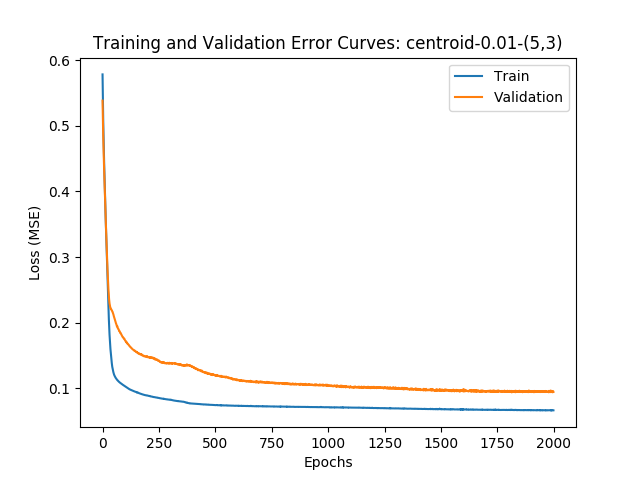

<IPython.core.display.Javascript object>


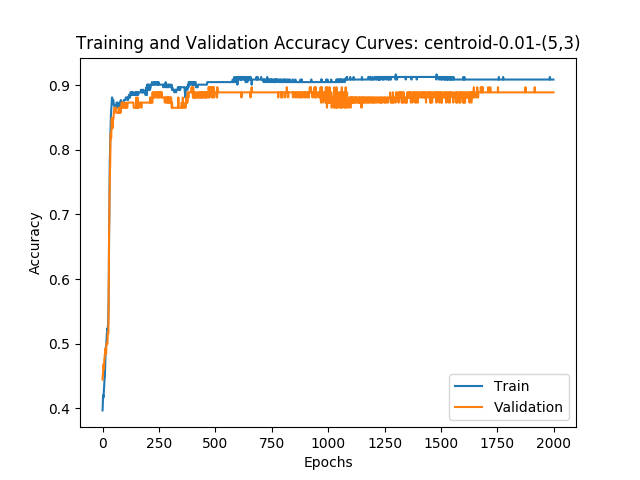

Matriz de confusão
[[1656  242]
 [   8   56]]

Train Loss:       0.0667
Validation Loss:  0.0936
Accuracy:         0.8726
MSE:              0.1274
AUROC:            0.9291


In [37]:
plot_training_error_curves(history, "centroid-0.01-(5,3)")
plot_training_acc_curves(history, "centroid-0.01-(5,3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [41]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4959 - acc: 0.5000 - val_loss: 0.4975 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4940 - acc: 0.5000 - val_loss: 0.4955 - val_acc: 0.4921
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4918 - acc: 0.5000 - val_loss: 0.4932 - val_acc: 0.4921
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4893 - acc: 0.5000 - val_loss: 0.4903 - val_acc: 0.4841
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4859 - acc: 0.4960 - val_loss: 0.4859 - val_acc: 0.4841
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4813 - acc: 0.4960 - val_loss: 0.4798 - val_acc: 0.4841
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4746 - acc: 0.4960 - val_loss: 0.4718 - val_acc: 0.4841
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4651 - acc

252/252 [==============================] - 0s - loss: 0.1389 - acc: 0.8452 - val_loss: 0.1713 - val_acc: 0.8095
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1379 - acc: 0.8452 - val_loss: 0.1716 - val_acc: 0.8095
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1368 - acc: 0.8373 - val_loss: 0.1716 - val_acc: 0.8175
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1360 - acc: 0.8373 - val_loss: 0.1718 - val_acc: 0.8175
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1353 - acc: 0.8413 - val_loss: 0.1720 - val_acc: 0.8175
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1344 - acc: 0.8452 - val_loss: 0.1721 - val_acc: 0.8175
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1337 - acc: 0.8492 - val_loss: 0.1722 - val_acc: 0.8254
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1330 - acc: 0.8492 - val_loss: 0.1725 - val_acc: 0.8254
Epoch 

252/252 [==============================] - 0s - loss: 0.1108 - acc: 0.8929 - val_loss: 0.1806 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1105 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1101 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8651
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1099 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8651
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8929 - val_loss: 0.1804 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8929 - val_loss: 0.1803 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1093 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.9048 - val_loss: 0.1751 - val_acc: 0.8651
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.1022 - acc: 0.9008 - val_loss: 0.1753 - val_acc: 0.8651
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.9048 - val_loss: 0.1746 - val_acc: 0.8651
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.1020 - acc: 0.9048 - val_loss: 0.1742 - val_acc: 0.8651
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.9048 - val_loss: 0.1738 - val_acc: 0.8651
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.9008 - val_loss: 0.1737 - val_acc: 0.8651
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.1017 - acc: 0.9048 - val_loss: 0.1740 - val_acc: 0.8651
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.9048 - val_loss: 0.1742 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8968 - val_loss: 0.1683 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8968 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1688 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1692 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8968 - val_loss: 0.1688 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8968 - val_loss: 0.1685 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8968 - val_loss: 0.1683 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0946 - acc: 0.8929 - val_loss: 0.1641 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0946 - acc: 0.8929 - val_loss: 0.1638 - val_acc: 0.8730
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1638 - val_acc: 0.8730
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8929 - val_loss: 0.1641 - val_acc: 0.8730
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8929 - val_loss: 0.1643 - val_acc: 0.8730
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8968 - val_loss: 0.1641 - val_acc: 0.8730
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8929 - val_loss: 0.1640 - val_acc: 0.8730
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8929 - val_loss: 0.1638 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8849 - val_loss: 0.1601 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1606 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1605 - val_acc: 0.8730
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1606 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1608 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1610 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1591 - val_acc: 0.8730
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1589 - val_acc: 0.8730
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1585 - val_acc: 0.8730
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1586 - val_acc: 0.8730
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1589 - val_acc: 0.8730
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1590 - val_acc: 0.8730
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1590 - val_acc: 0.8730
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8929 - val_loss: 0.1585 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1584 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1589 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1587 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1594 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1595 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1598 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8968 - val_loss: 0.1601 - val_acc: 0.8730
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8968 - val_loss: 0.1600 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8968 - val_loss: 0.1575 - val_acc: 0.8730
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8968 - val_loss: 0.1577 - val_acc: 0.8730
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8968 - val_loss: 0.1572 - val_acc: 0.8730
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1577 - val_acc: 0.8730
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1576 - val_acc: 0.8730
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1577 - val_acc: 0.8730
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1574 - val_acc: 0.8730
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1577 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9048 - val_loss: 0.1589 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.9048 - val_loss: 0.1588 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.9048 - val_loss: 0.1585 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9008 - val_loss: 0.1584 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1583 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1589 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1590 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.9008 - val_loss: 0.1595 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1570 - val_acc: 0.8889
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1572 - val_acc: 0.8889
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1572 - val_acc: 0.8889
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1566 - val_acc: 0.8889
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1567 - val_acc: 0.8889
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1572 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.8968 - val_loss: 0.1537 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8889
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1528 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1525 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1533 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1534 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1529 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9008 - val_loss: 0.1509 - val_acc: 0.8889
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9008 - val_loss: 0.1505 - val_acc: 0.8889
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9008 - val_loss: 0.1505 - val_acc: 0.8889
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9008 - val_loss: 0.1505 - val_acc: 0.8889
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.9008 - val_loss: 0.1506 - val_acc: 0.8889
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9008 - val_loss: 0.1514 - val_acc: 0.8889
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.9008 - val_loss: 0.1512 - val_acc: 0.8889
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9008 - val_loss: 0.1504 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1481 - val_acc: 0.8889
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1473 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1470 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1470 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1477 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1477 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1448 - val_acc: 0.8889
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1447 - val_acc: 0.8889
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1443 - val_acc: 0.8889
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1447 - val_acc: 0.8889
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1443 - val_acc: 0.8889
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1444 - val_acc: 0.8889
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1445 - val_acc: 0.8889
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9008 - val_loss: 0.1449 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1423 - val_acc: 0.8889
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1419 - val_acc: 0.8889
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1411 - val_acc: 0.8889
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1411 - val_acc: 0.8889
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1409 - val_acc: 0.8889
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1407 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1414 - val_acc: 0.8889
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1412 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1388 - val_acc: 0.8889
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1387 - val_acc: 0.8889
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1380 - val_acc: 0.8889
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1384 - val_acc: 0.8889
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1386 - val_acc: 0.8889
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1387 - val_acc: 0.8889
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1381 - val_acc: 0.8889
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1378 - val_acc:

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8889
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1358 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1355 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1359 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1364 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1359 - val_acc: 0.8889
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1361 - val_acc:

252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1341 - val_acc: 0.8889
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1348 - val_acc: 0.8889
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8889
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1346 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1342 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1343 - val_acc: 0.8889
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1346 - val_acc: 0.8889
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1344 - val_acc:

252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9048 - val_loss: 0.1334 - val_acc: 0.8889
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1327 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9048 - val_loss: 0.1330 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9048 - val_loss: 0.1331 - val_acc: 0.8889
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1330 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1331 - val_acc: 0.8889
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1330 - val_acc:

252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9087 - val_loss: 0.1319 - val_acc: 0.8889
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9048 - val_loss: 0.1317 - val_acc: 0.8889
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9087 - val_loss: 0.1322 - val_acc: 0.8889
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9087 - val_loss: 0.1320 - val_acc: 0.8889
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1325 - val_acc: 0.8810
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9048 - val_loss: 0.1323 - val_acc: 0.8889
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9087 - val_loss: 0.1326 - val_acc:

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1319 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1317 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1318 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1319 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1314 - val_acc:

252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9048 - val_loss: 0.1316 - val_acc: 0.8730
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9048 - val_loss: 0.1313 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9048 - val_loss: 0.1311 - val_acc: 0.8810
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9048 - val_loss: 0.1312 - val_acc: 0.8810
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9048 - val_loss: 0.1316 - val_acc: 0.8810
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9048 - val_loss: 0.1313 - val_acc: 0.8810
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9048 - val_loss: 0.1313 - val_acc:

252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1317 - val_acc: 0.8730
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1313 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1318 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1312 - val_acc: 0.8810
Epoch 1543/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1312 - val_acc:

252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1320 - val_acc: 0.8810
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8810
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1319 - val_acc: 0.8810
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1324 - val_acc: 0.8730
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1324 - val_acc: 0.8730
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1323 - val_acc: 0.8730
Epoch 1607/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1322 - val_acc:

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1325 - val_acc: 0.8730
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1325 - val_acc: 0.8730
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8730
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1326 - val_acc: 0.8730
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1328 - val_acc: 0.8730
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8730
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1326 - val_acc:

252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1335 - val_acc: 0.8730
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1336 - val_acc: 0.8730
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1336 - val_acc: 0.8730
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1335 - val_acc: 0.8810
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1333 - val_acc: 0.8810
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1337 - val_acc: 0.8810
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1335 - val_acc: 0.8810
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1334 - val_acc:

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8730
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1342 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8730
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1343 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1343 - val_acc: 0.8730
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1346 - val_acc:

252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1349 - val_acc: 0.8730
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1349 - val_acc: 0.8730
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1349 - val_acc: 0.8730
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1352 - val_acc: 0.8730
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1352 - val_acc: 0.8730
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1353 - val_acc: 0.8730
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1352 - val_acc: 0.8730
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1348 - val_acc:

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1356 - val_acc: 0.8730
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1362 - val_acc: 0.8730
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1362 - val_acc: 0.8730
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1361 - val_acc: 0.8730
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1361 - val_acc: 0.8730
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1357 - val_acc: 0.8730
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1356 - val_acc: 0.8730
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1355 - val_acc:

252/252 [==============================] - ETA: 0s - loss: 0.0765 - acc: 0.906 - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8730
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1368 - val_acc: 0.8730
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8730
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8730
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1368 - val_acc: 0.8730
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1371 - val_acc: 0.8730
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1368 - val_acc: 0.8730
Epoch 1989/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096605206772335681, 0.87971457684076526]


<IPython.core.display.Javascript object>


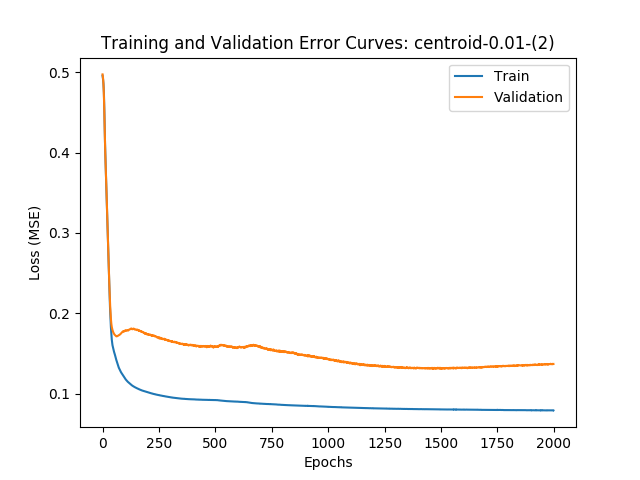

<IPython.core.display.Javascript object>


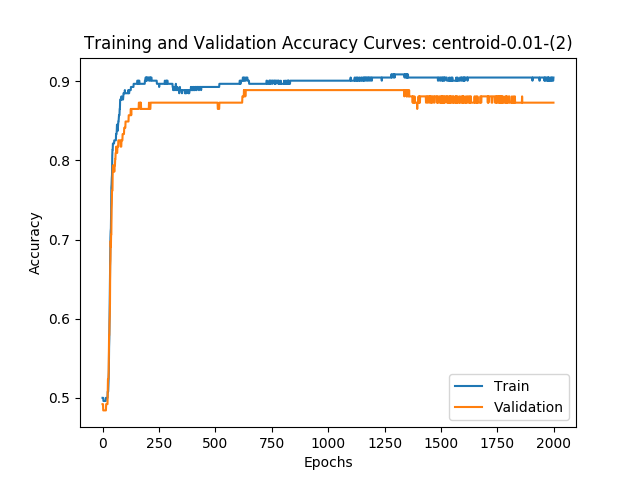

Matriz de confusão
[[1671  227]
 [   8   56]]

Train Loss:       0.0804
Validation Loss:  0.1308
Accuracy:         0.8802
MSE:              0.1198
AUROC:            0.9279


In [43]:
plot_training_error_curves(history, "centroid-0.01-(2)")
plot_training_acc_curves(history, "centroid-0.01-(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [44]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4590 - acc: 0.4563 - val_loss: 0.5013 - val_acc: 0.4762
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4406 - acc: 0.4563 - val_loss: 0.4822 - val_acc: 0.4841
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4232 - acc: 0.4563 - val_loss: 0.4639 - val_acc: 0.4841
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4060 - acc: 0.4643 - val_loss: 0.4435 - val_acc: 0.4841
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3900 - acc: 0.4722 - val_loss: 0.4242 - val_acc: 0.4921
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3735 - acc: 0.4722 - val_loss: 0.4048 - val_acc: 0.5079
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3557 - acc: 0.4881 - val_loss: 0.3862 - val_acc: 0.5079
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.3372 - acc

252/252 [==============================] - 0s - loss: 0.0968 - acc: 0.8849 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.0967 - acc: 0.8849 - val_loss: 0.1343 - val_acc: 0.8730
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1337 - val_acc: 0.8730
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.0964 - acc: 0.8849 - val_loss: 0.1333 - val_acc: 0.8730
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8849 - val_loss: 0.1334 - val_acc: 0.8730
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8849 - val_loss: 0.1332 - val_acc: 0.8651
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8849 - val_loss: 0.1335 - val_acc: 0.8730
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8849 - val_loss: 0.1337 - val_acc: 0.8730
Epoch 

252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8849 - val_loss: 0.1251 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8849 - val_loss: 0.1242 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8849 - val_loss: 0.1239 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1240 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1241 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8849 - val_loss: 0.1238 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8849 - val_loss: 0.1239 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8849 - val_loss: 0.1235 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.8730
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8929 - val_loss: 0.1178 - val_acc: 0.8730
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8929 - val_loss: 0.1186 - val_acc: 0.8730
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8929 - val_loss: 0.1190 - val_acc: 0.8730
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8929 - val_loss: 0.1189 - val_acc: 0.8730
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8929 - val_loss: 0.1188 - val_acc: 0.8730
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1184 - val_acc: 0.8730
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8929 - val_loss: 0.1181 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1157 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1155 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1152 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1149 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1147 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1144 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8968 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8968 - val_loss: 0.1118 - val_acc: 0.8730
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8968 - val_loss: 0.1117 - val_acc: 0.8730
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.8968 - val_loss: 0.1121 - val_acc: 0.8730
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.8968 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.8968 - val_loss: 0.1110 - val_acc: 0.8810
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.8968 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8968 - val_loss: 0.1107 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8968 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.8968 - val_loss: 0.1098 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - ETA: 0s - loss: 0.0701 - acc: 0.968 - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.8968 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.896

252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.8929 - val_loss: 0.1105 - val_acc: 0.8810
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.8929 - val_loss: 0.1107 - val_acc: 0.8810
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.8929 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.8929 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.8929 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.8929 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.8929 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.8929 - val_loss: 0.1104 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.8929 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.8968 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8810
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1103 - val_acc: 0.8889
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.8968 - val_loss: 0.1116 - val_acc: 0.8889
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1122 - val_acc: 0.8889
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1114 - val_acc: 0.8889
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1125 - val_acc: 0.8889
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1181 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1172 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.1168 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1162 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1163 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.1159 - val_acc: 0.8889
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.1153 - val_acc: 0.8889
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.1150 - val_acc: 0.8889
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8889
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.1152 - val_acc: 0.8889
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.1153 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8968
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.1141 - val_acc: 0.8968
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9087 - val_loss: 0.1143 - val_acc: 0.8968
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9087 - val_loss: 0.1142 - val_acc: 0.8968
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8968
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.1142 - val_acc: 0.8968
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9087 - val_loss: 0.1140 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8968
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9087 - val_loss: 0.1150 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9087 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9127 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9087 - val_loss: 0.1147 - val_acc: 0.8810
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8889
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8810
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9087 - val_loss: 0.1144 - val_acc: 0.8810
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1143 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9087 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9087 - val_loss: 0.1137 - val_acc:

252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9087 - val_loss: 0.1138 - val_acc: 0.8810
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9087 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9087 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9087 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9087 - val_loss: 0.1142 - val_acc: 0.8810
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0713 - acc: 0.9087 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9087 - val_loss: 0.1144 - val_acc: 0.8810
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9087 - val_loss: 0.1138 - val_acc:

252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1142 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1145 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.1142 - val_acc:

252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9048 - val_loss: 0.1153 - val_acc: 0.8730
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.1145 - val_acc: 0.8810
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9087 - val_loss: 0.1147 - val_acc: 0.8810
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.1152 - val_acc: 0.8810
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9087 - val_loss: 0.1152 - val_acc:

252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1150 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9087 - val_loss: 0.1153 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1155 - val_acc: 0.8730
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1157 - val_acc: 0.8730
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1152 - val_acc:

252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1158 - val_acc: 0.8810
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8730
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8730
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8730
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.1157 - val_acc:

252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1166 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8730
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.1169 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1162 - val_acc: 0.8730
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8730
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1167 - val_acc:

252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.1165 - val_acc: 0.8730
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.1166 - val_acc: 0.8730
Epoch 1475/2000
252/252 [==============================] - ETA: 0s - loss: 0.0485 - acc: 0.937 - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1168 - val_acc: 0.8730
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1173 - val_acc: 0.8730
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1176 - val_acc: 0.8730
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.1173 - val_acc: 0.8730
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc

252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1172 - val_acc: 0.8730
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8730
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1183 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1176 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1175 - val_acc: 0.8730
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1173 - val_acc:

252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1177 - val_acc: 0.8730
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8730
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1184 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1183 - val_acc: 0.8730
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8730
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8730
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1174 - val_acc:

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.1187 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8571
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.1189 - val_acc: 0.8651
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.1185 - val_acc:

252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.1196 - val_acc: 0.8651
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1191 - val_acc: 0.8651
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9087 - val_loss: 0.1191 - val_acc: 0.8651
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9087 - val_loss: 0.1200 - val_acc: 0.8571
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9048 - val_loss: 0.1198 - val_acc: 0.8651
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1196 - val_acc: 0.8651
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1192 - val_acc:

252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1195 - val_acc: 0.8571
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1208 - val_acc: 0.8571
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1203 - val_acc: 0.8571
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9048 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1194 - val_acc:

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1209 - val_acc: 0.8571
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9048 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8651
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9048 - val_loss: 0.1213 - val_acc: 0.8571
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9048 - val_loss: 0.1209 - val_acc: 0.8571
Epoch 1862/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1204 - val_acc:

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1210 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1215 - val_acc: 0.8571
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1215 - val_acc: 0.8571
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1213 - val_acc: 0.8571
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1214 - val_acc:

252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9048 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1217 - val_acc: 0.8651
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9087 - val_loss: 0.1217 - val_acc: 0.8571
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1215 - val_acc: 0.8651
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1213 - val_acc: 0.8651
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 1989/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9087 - val_loss: 0.1223 - val_acc:

In [45]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096186774312903026, 0.89551478071436363]


<IPython.core.display.Javascript object>


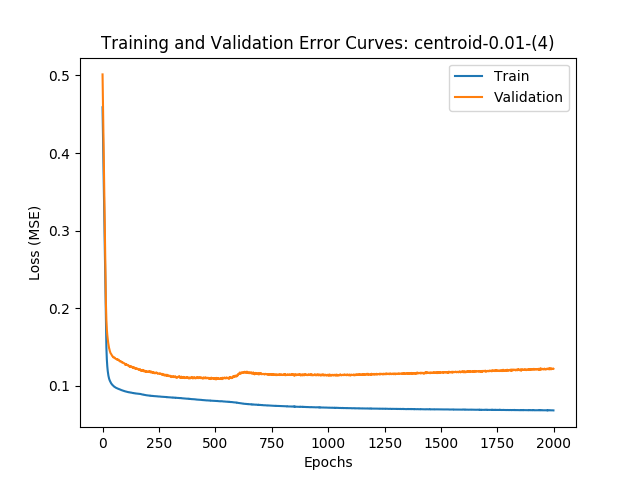

<IPython.core.display.Javascript object>


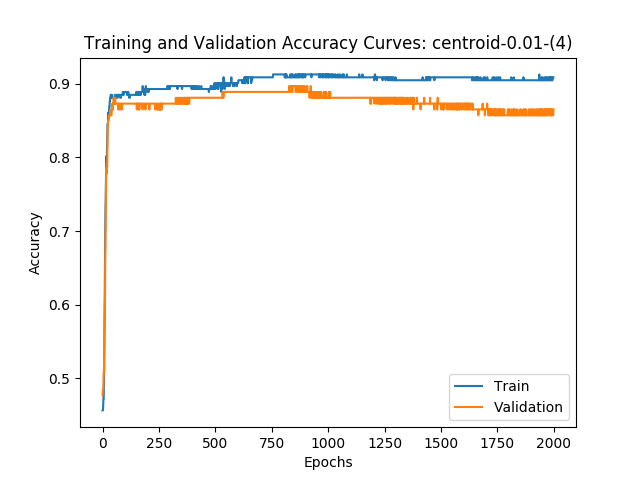

Matriz de confusão
[[1702  196]
 [   9   55]]

Train Loss:       0.0806
Validation Loss:  0.1082
Accuracy:         0.8955
MSE:              0.1045
AUROC:            0.9385


In [46]:
plot_training_error_curves(history, "centroid-0.01-(4)")
plot_training_acc_curves(history, "centroid-0.01-(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))